In [321]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np


In [319]:
df= pd.read_csv('Financial-Campaign-full.csv')#loads the csv file into a pandas dataframe
corr_df = pd.read_csv('Financial-Campaign-full.csv')
df.head() #returns the first 5 rows

,Age,Job,Marital,Education,Credit?,Balance,HousingLoan,PersonalLoan,Contact,LastDay,LastMonth,ContactDuration,CampaignContacts,Pdays,PreviousContacts,POutcome,Coutcome
0,34,blue-collar,married,secondary,no,7216,yes,no,unknown,26,may,143,2,-1,0,unknown,no
1,29,housemaid,married,secondary,no,823,yes,no,unknown,23,may,14,2,-1,0,unknown,no
2,41,blue-collar,married,primary,no,17,no,no,cellular,8,jul,117,3,-1,0,unknown,no
3,37,technician,married,secondary,no,729,yes,no,cellular,15,jul,115,5,-1,0,unknown,no
4,32,blue-collar,single,secondary,no,15341,no,no,unknown,21,may,738,3,-1,0,unknown,no


## Data Exploration

There are 10 non numeric columns that we need to consider if we want to include that in our analysis because we will need to convert them to numeric values for clustering purposes.

In [281]:
df.shape # 45000 rows 17 cols, lots of data!

(45208, 17)

In [282]:
df.dtypes

Age                  int64
Job                 object
Marital             object
Education           object
Credit?             object
Balance              int64
HousingLoan         object
PersonalLoan        object
Contact             object
LastDay              int64
LastMonth           object
ContactDuration      int64
CampaignContacts     int64
Pdays                int64
PreviousContacts     int64
POutcome            object
Coutcome            object
dtype: object

In [320]:
corr_df['Coutcome'].replace(['yes', 'no'],[0, 1], inplace=True)
corr_df.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_4352\132407485.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  corr_df['Coutcome'].replace(['yes', 'no'],[0, 1], inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_4352\132407485.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_df['Coutcome'].

,Age,Job,Marital,Education,Credit?,Balance,HousingLoan,PersonalLoan,Contact,LastDay,LastMonth,ContactDuration,CampaignContacts,Pdays,PreviousContacts,POutcome,Coutcome
0,34,blue-collar,married,secondary,no,7216,yes,no,unknown,26,may,143,2,-1,0,unknown,1
1,29,housemaid,married,secondary,no,823,yes,no,unknown,23,may,14,2,-1,0,unknown,1
2,41,blue-collar,married,primary,no,17,no,no,cellular,8,jul,117,3,-1,0,unknown,1
3,37,technician,married,secondary,no,729,yes,no,cellular,15,jul,115,5,-1,0,unknown,1
4,32,blue-collar,single,secondary,no,15341,no,no,unknown,21,may,738,3,-1,0,unknown,1


From the findings of the POutcome column, majority of this column has unknown values. Based on these findings, we decided that this is not a good column to include in our 

Avg age is 40.9, medium age is 39, oldest is 95, youngest is 18.

This tells us here are alot of middle aged people starting from 30 to 60

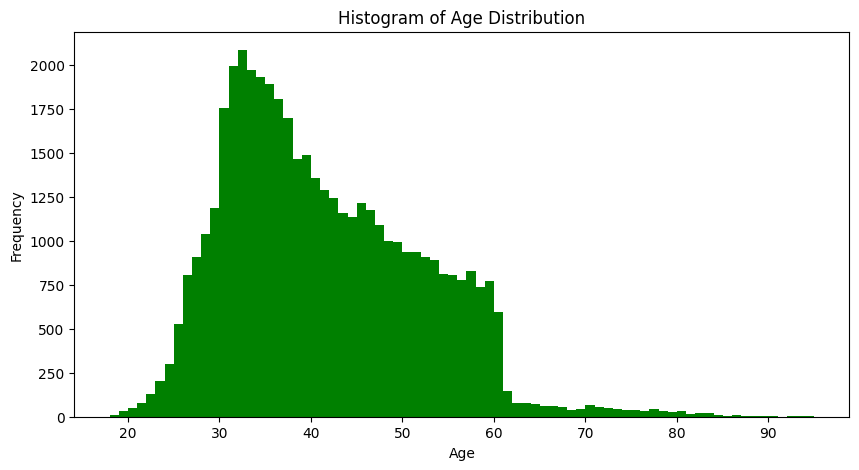

In [284]:
# Age stuff
plt.figure(figsize=(10, 5))
plt.hist(df['Age'].values, rwidth=1, bins =77, color='green')
plt.title('Histogram of Age Distribution')
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.show()

The below code is creating a pie chart for all individuals that have above average balances based on their marital status. Throughout our analysis we have also noticed about 26% of all individuals are above the mean (average) balance. We are inferring that the financial institutions marketing campaign for higher balance individuals will only affect 26% of their customers.

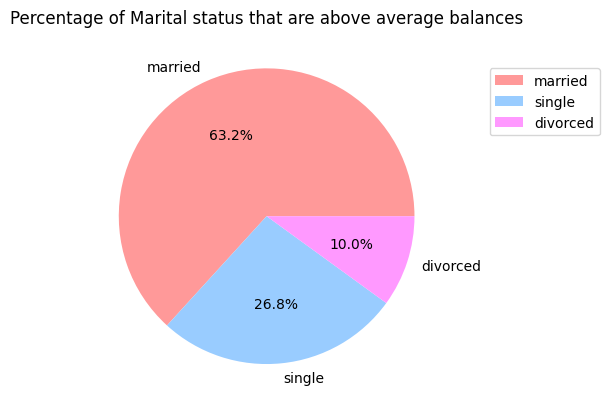

In [285]:

average_balance = df['Balance'].mean() 

above_average_bal = len(df[df['Balance'] > average_balance]) #number of people that have above average balances
#df.describe()

marital_titles = df['Marital'].value_counts().index.to_list()


marital_above_average_bal = [] 
status_total = 0
marital_percentage_above_average_bal = []


for m in marital_titles: 
    status_total = df[df['Marital'] == m]
    marital_above_average_bal.append(len(status_total[status_total['Balance'] > average_balance]))

total_count = sum(marital_above_average_bal)
for marital in marital_above_average_bal:
    marital_percentage_above_average_bal.append(marital / total_count * 100)

bar_colors = ['#FF9999', '#99CCFF', '#FF99FF']

plt.pie(marital_percentage_above_average_bal,  colors=bar_colors, labels=marital_titles,autopct='%1.1f%%')

plt.title('Percentage of Marital status that are above average balances')
plt.legend(loc="lower right", bbox_to_anchor=(1.42,0.7))
 
plt.show()


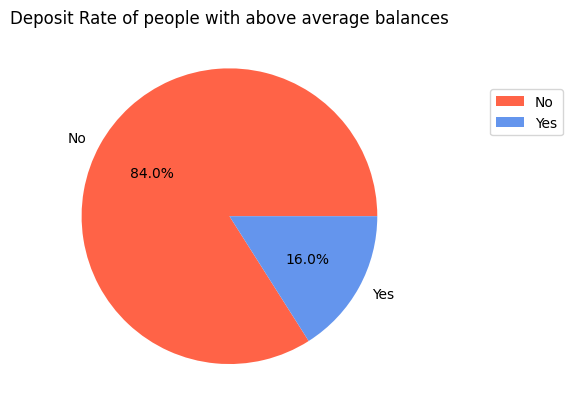

[84.00442666212649, 15.9955733378735]


In [286]:
#people with above average balances
above_average_bal = df[df['Balance'] > average_balance]

# number of people that put down a term deposit vs people that did not put down a term deposit
NoDeposit = len(above_average_bal[above_average_bal["Coutcome"] =='no'])
YesDeposit = len(above_average_bal[above_average_bal["Coutcome"] =='yes'])

#print(NoDeposit)
#print(YesDeposit)




total_cooutcome = []
total_cooutcome.append(NoDeposit/len(above_average_bal) * 100)
total_cooutcome.append(YesDeposit/len(above_average_bal) * 100)
#plt.bar(above_average_bal['Coutcome'].unique(), above_average_bal["Coutcome"].value_counts(), color=bar_colors, align='center', width=0.5) =
plt.pie(total_cooutcome,  colors=[ 'tomato', 'cornflowerblue'], labels=['No', 'Yes'], autopct='%1.1f%%')


plt.legend(loc="lower right", bbox_to_anchor=(1.42,0.7))
plt.title('Deposit Rate of people with above average balances')

plt.show()
print(total_cooutcome)

<h1> Percentage of Individuals are above the mean (average) balance <h1>

In [287]:
print(total_count / len(df) * 100)

25.984339055034507


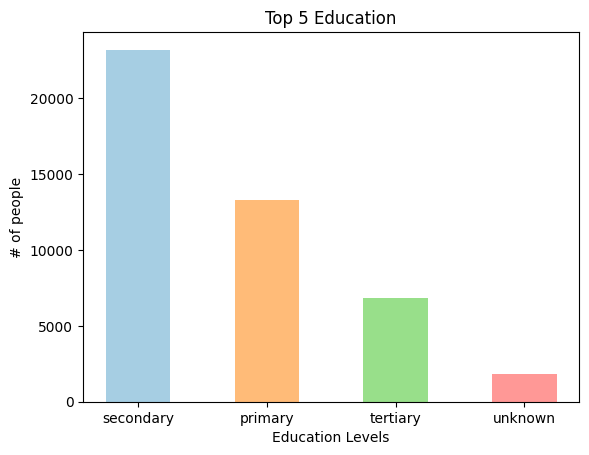

In [288]:
bar_colors = ['#a6cee3', '#ffbb78', '#98df8a', '#ff9896', '#cfa3e3']

plt.bar(df['Education'].unique(), df["Education"].value_counts(), color=bar_colors, align='center', width=0.5)

plt.ylabel('# of people')
plt.xlabel('Education Levels')
plt.title('Top 5 Education')

plt.show()

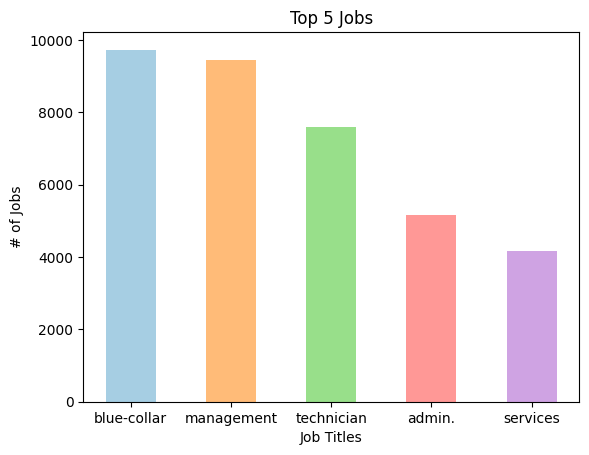

In [289]:
job_title = df['Job'].value_counts()[:5].index.to_list()

job_counts = df['Job'].value_counts()[:5]

# Convert the value counts to a NumPy array
job_counts_array = job_counts.values

#job_title = ['Blue Collar', 'House Maid', 'Technician', 'Management', 'Entrepreneur']

bar_colors = ['#a6cee3', '#ffbb78', '#98df8a', '#ff9896', '#cfa3e3']

plt.bar(job_title, job_counts, color=bar_colors, label=job_title, align='center', width=0.5)

plt.ylabel('# of Jobs')
plt.xlabel('Job Titles')
plt.title('Top 5 Jobs')
#plt.legend(title='Fruit color')

plt.show()



Bar Chart of different jobs that have credit or not 

<h2>Data Cleaning<h2>

In [290]:
clean_df = df

<h1>Missing values<h1>

The first step of data cleaning would be to see if there is any values that are null, as you can see there is no null values 

In [291]:
 #returns the number of missing values   
clean_df.isnull().sum() 

Age                 0
Job                 0
Marital             0
Education           0
Credit?             0
Balance             0
HousingLoan         0
PersonalLoan        0
Contact             0
LastDay             0
LastMonth           0
ContactDuration     0
CampaignContacts    0
Pdays               0
PreviousContacts    0
POutcome            0
Coutcome            0
dtype: int64

The second step of data cleaning would be to see if there are any values that are empty

In [292]:
 #returns the number of missing values
clean_df.isna().sum() 

Age                 0
Job                 0
Marital             0
Education           0
Credit?             0
Balance             0
HousingLoan         0
PersonalLoan        0
Contact             0
LastDay             0
LastMonth           0
ContactDuration     0
CampaignContacts    0
Pdays               0
PreviousContacts    0
POutcome            0
Coutcome            0
dtype: int64

<h1>Find all the Job names<h1>

As you can see for Admin role there is an extra period added to the end of the data which we will remove the period from the dataset  

In [293]:
clean_df['Job'].unique()

array(['blue-collar', 'housemaid', 'technician', 'management',
       'entrepreneur', 'admin.', 'services', 'self-employed', 'retired',
       'unemployed', 'unknown', 'student'], dtype=object)

<h1>Find all the month names<h1> 

As you can see for lastMonth column there is incorrectly typed Month of may which includes two Y's, we will replace the existing value back to correct format


In [294]:
#Find all the unique month columns 
clean_df['LastMonth'].unique()

array(['may', 'jul', 'jun', 'mayY', 'aug', 'oct', 'nov', 'dec', 'jan',
       'feb', 'mar', 'apr', 'sep'], dtype=object)

Entry #13 has an error month is labeled as mayY (drop this record or replace)
jobs has unknown

In [298]:
# We will replace the mayY with may 

clean_df['LastMonth'].replace('mayY', 'may', inplace=True)

#We will replace the admin. with admin
clean_df['Job'].replace('admin.', 'admin', inplace=True)


C:\Users\PC\AppData\Local\Temp\ipykernel_4352\3969752105.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_df['LastMonth'].replace('mayY', 'may', inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_4352\3969752105.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

Verifying that month and job columns have clean data

In [305]:
clean_df[(clean_df['LastMonth'] == 'mayY')]

,Age,Job,Marital,Education,Credit?,Balance,HousingLoan,PersonalLoan,Contact,LastDay,LastMonth,ContactDuration,CampaignContacts,Pdays,PreviousContacts,POutcome,Coutcome


In [306]:
clean_df[(clean_df['Job'] == 'admin.')]

,Age,Job,Marital,Education,Credit?,Balance,HousingLoan,PersonalLoan,Contact,LastDay,LastMonth,ContactDuration,CampaignContacts,Pdays,PreviousContacts,POutcome,Coutcome


jobs, Education, Contact(this one may not be issue), POutcome has unknons
Last month has a mayY value
Pdays has a -1 value may not be issue
LastDay has 1 value above 600

<h1>Dropping the LastDay column <h1>

In our findings we found that there was one outlier which had value of 628 which doesn't make sense for LastDay communciated by the financial institute. We also decided that we aren't going to be use the LastDay column in our clustering process so we will drop this column completely 

In [ ]:
#clean_df.drop(columns=['LastMonth'])

Clustering Ideas

best month for marketting campaign

avg # contacts per month

new vs old people Coutcome



This financial institution is very new considering the number of new

In [297]:
df['POutcome'].value_counts()

#df[(df['Pdays'] == -1)]['POutcome'].value_counts()]

#36951
#failure     4901


# New marketing campaign reached a broader audience but overal the percenetage of success was very low 
#df[(df['Pdays'] == -1)]["Coutcome"].value_counts()

# Old 
#df[(df['Pdays'] != -1)]["Coutcome"].value_counts()


#df[(df['Pdays'] == -1)][['Pdays', 'POutcome']].value_counts()

POutcome
unknown    36956
failure     4901
other       1840
success     1511
Name: count, dtype: int64